## 1. INITIATION & READING DATA

In [76]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


print('** HOUSE PRICES - ADVANCED REGRESSION TECHNIQUES **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

print ("Initiation is DONE !!")
print("-"*25)

** HOUSE PRICES - ADVANCED REGRESSION TECHNIQUES **
-------------------------
data_description.txt
sample_submission.csv
test.csv
train.csv
-------------------------
Initiation is DONE !!
-------------------------


In [2]:
##### SOME USEFULL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )
    
    
def null_detector(x):
    missing = x.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(15,6) )
    sns.barplot( x=missing.index, y=missing.values)
    plt.title( f'Total Column: {x.shape[1]} --- Missing Column: {len(missing)} ({round(len(missing)*100/x.shape[1],2)}%) ' )
    plt.xticks(rotation=60)
    
    for p in ax.patches:
        ax.annotate( '{:.2f}'.format(p.get_height()/x.shape[0]),  (p.get_x() , p.get_height() + 3), fontsize=11 )  
    plt.show()
    
    
def target_dist_visualizer(y):
    import scipy.stats as st
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4) )

    sns.distplot(y, kde=True, fit=st.norm, ax=ax1)
    ax1.set(title='Normal')

    sns.distplot(y, kde=True, fit=st.lognorm, ax=ax2)
    ax2.set(title='Log Normal')

    sns.distplot(y, kde=True, fit=st.johnsonsu, ax=ax3)
    ax3.set(title='Johnson SU')
    plt.show()
    print('-'*120)
    
    df_res = pd.DataFrame({ 'normaltest-stat': [ st.normaltest(y)[0]  ],
                            'normaltest-p'   : [ st.normaltest(y)[1]  ],
                            'shapiro-stat'   : [ st.shapiro(y)[0]     ],
                            'shapiro-p'      : [ st.shapiro(y)[1]     ],
                            'anderson-stat'  : [ st.anderson(y, dist='norm')[0] ],
                            'anderson-crit'  : [ st.anderson(y, dist='norm')[1]  ],
                            'anderson-sgnf'  : [ st.anderson(y, dist='norm')[2]  ]   })
    
    return df_res

    
def num_col_visualizer(train, test, num_cols, target, box_limit=10):
    i=0
    for col in num_cols:
        i += 1
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5) )
        # plt.suptitle(col, fontsize=20)

        ## FIRST SUBPLOT
        if train[col].nunique() <= box_limit:
            sns.boxplot(data=train,  x=col, y=target, ax=ax1)
        else:
            sns.scatterplot( data=train,  x=col, y=target, ax=ax1)

        ax1.set( title = str(i) + '. ' + col + ' vs. ' + target ) 

        ## SECOND SUBPLOT
        try:
            sns.distplot(train[col], kde=True, ax=ax2)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(train[col], kde=True, kde_kws={'bw': 0.1}, ax=ax2)
            else:
                raise re
        ax2.set( title = 'Train --- Null: ' + str(train[col].isnull().sum()) + ' --- Unique: ' + str( train[col].nunique()  ) )

        ## THIRD SUBPLOT
        try:
            sns.distplot(test[col], kde=True, ax=ax3)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(test[col], kde=True, kde_kws={'bw': 0.1}, ax=ax3)
            else:
                raise re
        ax3.set( title = 'Test --- Null: ' + str(test[col].isnull().sum())  + ' --- Unique: ' + str( test[col].nunique() ) )

        plt.show()
        print(train[col].describe(include='all'))
        print('-'*120)    


def str_col_visualizer(train, test, str_cols, target, box_limit=20):
    i = 0
    for col in str_cols:
        i+=1
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5) )
        # plt.suptitle(col, fontsize=20)

        ## FIRST SUBPLOT
        sns.boxplot(x=train[col].fillna('NaN'), y=train[target], ax=ax1)
        ax1.set( title = str(i) + '. ' + col + ' vs. ' + target ) 

        ## SECOND SUBPLOT
        h = train[col].value_counts()
        sns.barplot(x=h.index, y=h.values, ax=ax2)
        ax2.set( title = 'Train --- Null: ' + str(train[col].isnull().sum()) + ' --- Unique: ' + str( train[col].nunique()  ) )
        
        ## THIRD SUBPLOT
        g = test[col].value_counts()
        sns.barplot(x=g.index, y=g.values, ax=ax3)
        ax3.set( title = 'Test --- Null: ' + str(test[col].isnull().sum())  + ' --- Unique: ' + str( test[col].nunique() ) )
        
        plt.show()
        print(train[col].describe(include='all'))
        print('-'*120)  

def reg_with_one_exploratory_visualizer(df_train, exp_var, ind_var):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5) )
    # plt.suptitle(col, fontsize=20)

    ## FIRST SUBPLOT
    sns.regplot(x=df_train[exp_var], y=df_train[ind_var], ax=ax1)

    ## SECOND SUBPLOT
    sns.residplot(x=df_train[exp_var], y=df_train[ind_var], ax=ax2)

    plt.show()    

In [3]:
path = 'input/'
out_path = 'output/'

with timer():
    train      = pd.read_csv( f'{path}train.csv')
    test       = pd.read_csv( f'{path}test.csv')
    submission = pd.read_csv( f'{path}sample_submission.csv')

print('Reading Data is DONE !!')
print("-"*25)

print( f'train      shape :  {train.shape}       ')
print( f'test       shape :  {test.shape}        ')
print( f'submission shape :  {submission.shape}  ')

Runtime: 0.04 sn
Reading Data is DONE !!
-------------------------
train      shape :  (1460, 81)       
test       shape :  (1459, 80)        
submission shape :  (1459, 2)  


In [4]:
target   = 'SalePrice'
str_cols = [f for f in train.columns if train.dtypes[f] == 'object']
num_cols = [f for f in train.columns if train.dtypes[f] != 'object']
num_cols.remove(target)
num_cols.remove('Id')

print(len(str_cols))
print(len(num_cols))

43
36


In [5]:
train.dtypes.value_counts()

object     43
int64      35
float64    3 
dtype: int64

## TREATMENT OF TARGET VARIABLES

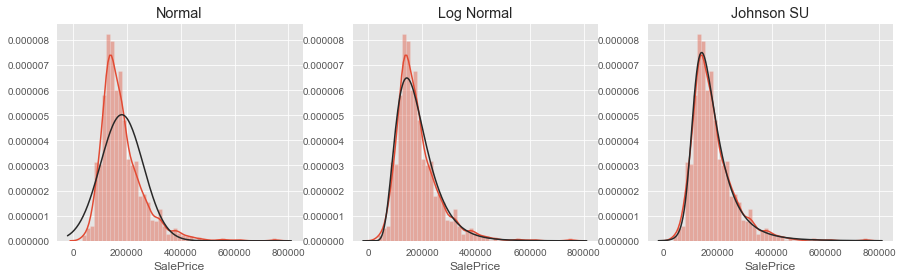

------------------------------------------------------------------------------------------------------------------------


,normaltest-stat,normaltest-p,shapiro-stat,shapiro-p,anderson-stat,anderson-crit,anderson-sgnf
0,610.835911,2.283848e-133,0.869672,3.206248e-33,41.691996,"[0.574, 0.654, 0.785, 0.916, 1.089]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [6]:
## This part will be improved with advanced methods
y = train[target]
target_dist_visualizer(y)

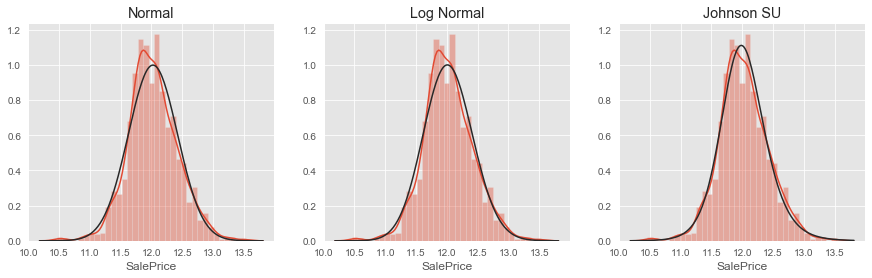

------------------------------------------------------------------------------------------------------------------------


,normaltest-stat,normaltest-p,shapiro-stat,shapiro-p,anderson-stat,anderson-crit,anderson-sgnf
0,25.507182,0.000003,0.991205,1.146761e-07,3.538807,"[0.574, 0.654, 0.785, 0.916, 1.089]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [7]:
## This part will be improved with advanced methods
y = np.log1p(train[target])
target_dist_visualizer(y)

In [8]:
## p < 0.05 indicates the rejection of null hypotesis, 
## (H0: that is the series comes from a normal distribution)

In [9]:
train[target] = np.log1p(train[target])

## NUMERICAL COLUMN VISUALISATION 

In [10]:
print(train.shape)
train = train[ ~( train['GrLivArea']   >= 4000 ) ]
print(train.shape)
train = train[ ~( train['LotFrontage'] >= 200  ) ]
print(train.shape)

(1460, 81)
(1456, 81)
(1455, 81)


In [11]:
df = pd.concat([train, test], axis=0, ignore_index=True )
print(df.shape)
df.tail()

(2914, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2909,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2910,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2911,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2912,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2913,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


In [12]:
df['LotFrontage'].median()

68.0

In [13]:
# num_col_visualizer(train, test, num_cols, target, box_limit=20)

In [14]:
## Numerical Features Simple Selection and Handling
# Seems like ordinal but it is not
df['fea_MSSubClass']         = df['MSSubClass'].apply(lambda x:  3 if ( (x==60) | (x==120) ) else 1 if ( (x==30) | (x==45) | (x==180) ) else 2 )
df['fea_LotFrontage']        = df['LotFrontage'].fillna( df['LotFrontage'].mean() )
df['fea_LotFrontage_log']    = df['fea_LotFrontage'].apply(np.log1p)
df['fea_LotArea']            = df['LotArea']
df['fea_LotArea_log']        = df['LotArea'].apply(np.log1p)
df['fea_OverallQual']        = df['OverallQual']
df['fea_OverallCond']        = df['OverallCond']
df['fea_YearBuilt']          = df['YearBuilt']
df['fea_YearRemodAdd']       = df['YearRemodAdd']
df['fea_YrSold']             = df['YrSold']

df['fea_MasVnrArea']         = df['MasVnrArea'].fillna(0).apply(np.log1p)
df['fea_BsmtFinSF1']         = df['BsmtFinSF1'].fillna(0)
df['fea_BsmtFinSF2']         = df['BsmtFinSF2'].fillna(0)
df['fea_BsmtUnfSF']          = df['BsmtUnfSF'].fillna(0)
df['fea_BsmtUnfSF_log']      = df['BsmtUnfSF'].fillna(0).apply(np.log1p)
df['fea_TotalBsmtSF']        = df['TotalBsmtSF'].fillna( df['TotalBsmtSF'].mean() )
df['fea_TotalBsmtSF_log']    = df['TotalBsmtSF'].fillna( df['TotalBsmtSF'].mean() ).apply(np.log1p)


df['fea_1stFlrSF']           = df['1stFlrSF']
df['fea_1stFlrSF_log']       = df['1stFlrSF'].apply(np.log1p)
df['fea_2ndFlrSF']           = df['2ndFlrSF']
df['fea_2ndFlrSF_log']       = df['2ndFlrSF'].apply(np.log1p)
# df['fea_LowQualFinSF']       = df['LowQualFinSF']
df['fea_GrLivArea']          = df['GrLivArea']
df['fea_GrLivArea_log']      = df['GrLivArea'].apply(np.log1p)

df['fea_BsmtFullBath']       = df['BsmtFullBath'].fillna(0)
df['fea_BsmtHalfBath']       = df['BsmtHalfBath'].fillna(0)
df['fea_BsmtTotalBath']      = df['BsmtHalfBath'].fillna(0) + (df['BsmtHalfBath'].fillna(0) / 2)

df['fea_FullBath']           = df['FullBath']
df['fea_HalfBath']           = df['HalfBath']
df['fea_TotalBath']          = df['FullBath'].fillna(0) + (df['HalfBath'].fillna(0) / 2)

df['fea_BedroomAbvGr']       = df['BedroomAbvGr']
df['fea_KitchenAbvGr']       = df['KitchenAbvGr'] 
df['fea_TotRmsAbvGrd']       = df['TotRmsAbvGrd']

df['fea_Fireplaces']         = df['Fireplaces']
df['fea_GarageYrBlt']        = df['GarageYrBlt'].fillna( df['GarageYrBlt'].mean() )
df['fea_GarageCars']         = df['GarageCars'].fillna(0)

df['fea_GarageArea']         = df['GarageArea'].fillna(0)
df['fea_GarageArea_log']     = df['GarageArea'].apply(np.log1p)
df['fea_WoodDeckSF']         = df['WoodDeckSF']

df['fea_OpenPorchSF']        = df['OpenPorchSF']
df['fea_EnclosedPorch']      = df['EnclosedPorch']
df['fea_3SsnPorch']          = df['3SsnPorch']
df['fea_ScreenPorch']        = df['ScreenPorch']
df['fea_TotalPorch']         = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

df['fea_PoolArea']           = df['PoolArea']
df['fea_MiscVal']            = df['MiscVal']

df['fea_MoSold']             = df['MoSold']
df['fea_YrSold']             = df['YrSold']

In [15]:
# str_col_visualizer(train, test, str_cols, target, box_limit=12)

In [16]:
# Encode some categorical features as ordered numbers when there is information in the order

In [17]:
## String Features (Some nominal some ordinal, treat carefully !! )
df['fea_MSZoning']         = df['MSZoning'].fillna( df['MSZoning'].value_counts().index[0] )
df['fea_MSZoning']         = df['fea_MSZoning'].map( dict(df.groupby(['fea_MSZoning'])['SalePrice'].median().sort_values()) )

tmp = pd.get_dummies(df['Street'], prefix='fea_Street')
tmp.drop('fea_Street_Grvl', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

tmp = pd.get_dummies(df['Alley'], prefix='fea_Alley')
df = pd.concat( [df, tmp], axis=1 )

df['fea_LotShape']   =  df['LotShape'].map(  {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4} )

tmp = pd.get_dummies(df['LandContour'], prefix='fea_LandContour')
tmp.drop('fea_LandContour_Lvl', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

## Skip Utilities

# No Hope
tmp = pd.get_dummies(df['LotConfig'], prefix='fea_LotConfig')
tmp.drop('fea_LotConfig_Inside', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

# No Hope
df['fea_LandSlope']   =  df['LandSlope'].map( {"Sev" : 3, "Mod" : 2, "Gtl" : 1} )

df['fea_Neighborhood']  = df['Neighborhood'].apply(lambda x: 3 if ( (x=='NoRidge') | (x=='NridgHt') | (x=='StoneBr') ) else
                                                            1 if ( (x=='IDOTRR')  | (x=='MeadowV') | (x=='BrDale' ) ) else 2 )
#No Hope
tmp = pd.get_dummies(df['Condition1'], prefix='fea_Condition1')
tmp.drop('fea_Condition1_Norm', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

#No Hope
tmp = pd.get_dummies(df['Condition2'], prefix='fea_Condition2')
tmp.drop('fea_Condition2_Norm', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

#No Hope
tmp = pd.get_dummies(df['BldgType'], prefix='fea_BldgType')
tmp.drop('fea_BldgType_1Fam', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_HouseStyle']         = df['HouseStyle'].map( dict(df.groupby(['HouseStyle'])['SalePrice'].median().sort_values()) )

# Skip RoofStyle
# Skip RoofMatl

#No Hope
tmp = pd.get_dummies(df['Exterior1st'], prefix='fea_Exterior1st')
tmp.drop( ['fea_Exterior1st_ImStucc', 'fea_Exterior1st_Stone' ], axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

#No Hope
tmp = pd.get_dummies(df['Exterior2nd'], prefix='fea_Exterior2nd')
tmp.drop( ['fea_Exterior2nd_Other'], axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

tmp = pd.get_dummies(df['MasVnrType'], prefix='fea_MasVnrType')
tmp.drop('fea_MasVnrType_None', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )


df['fea_ExterQual']   =  df['ExterQual'].map(  {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5} )
df['fea_ExterCond']   =  df['ExterCond'].map(  {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5} )

tmp = pd.get_dummies(df['Foundation'], prefix='fea_Foundation')
tmp.drop('fea_Foundation_Stone', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_BsmtQual']   =  df['BsmtQual'].map(  {np.nan:-1, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5} )

df['fea_BsmtCond']   =  df['BsmtCond'].map( {np.nan:-1, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

df['fea_BsmtExposure']   =  df['BsmtExposure'].map(   {np.nan:-1, "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3} )

df['fea_BsmtFinType1']   =  df['BsmtFinType1'].map(   {np.nan:-1, "Unf" : 0, "LwQ" : 1, "Rec" : 2, "BLQ" : 3, "ALQ" : 4, "GLQ" : 5} )
df['fea_BsmtFinType1_GLQ']   =  df['BsmtFinType1'].map(   {np.nan:-1, "Unf" : 0, "LwQ" : 0, "Rec" : 0, "BLQ" : 0, "ALQ" : 0, "GLQ" : 1} )

df['fea_BsmtFinType2']   =  df['BsmtFinType2'].map(   {np.nan:-1, "Unf" : 0, "LwQ" : 1, "Rec" : 2, "BLQ" : 3, "ALQ" : 4, "GLQ" : 5} )

#No Hope
tmp = pd.get_dummies(df['Heating'], prefix='fea_Heating')
tmp.drop(['fea_Heating_OthW', 'fea_Heating_Floor'], axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_HeatingQC']   =  df['HeatingQC'].map(   {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5} )

tmp = pd.get_dummies(df['CentralAir'], prefix='fea_CentralAir')
tmp.drop('fea_CentralAir_N', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_Electrical']   =  df['Electrical'].map(   {np.nan:5, "Mix" : 1, "FuseP" : 2, "FuseF" : 3, "FuseA" : 4, "SBrkr" : 5} )

df['fea_KitchenQual']   =  df['KitchenQual'].map( {np.nan:0, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

#No Hope
tmp = pd.get_dummies(df['Functional'], prefix='fea_Functional')
tmp.drop('fea_Functional_Typ', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_FireplaceQu']   =  df['FireplaceQu'].map( {np.nan:0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

tmp = pd.get_dummies(df['GarageType'], prefix='fea_GarageType')
df = pd.concat( [df, tmp], axis=1 )

df['fea_GarageFinish']   =  df['GarageFinish'].map( {np.nan:0, "Unf" : 1, "RFn" : 2, "Fin": 3}  )

df['fea_GarageQual']   =  df['GarageQual'].map( {np.nan:0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

df['fea_GarageCond']   =  df['GarageCond'].map( {np.nan:0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

df['fea_PavedDrive']   =  df['PavedDrive'].map( { "N" : 1, "P" : 2, "Y": 3}  )

df['fea_PoolQC']   =  df['PoolQC'].map( {np.nan:0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}  )

#Skip Fence

#No Hope
tmp = pd.get_dummies(df['MiscFeature'], prefix='fea_MiscFeature')
tmp.drop(['fea_MiscFeature_Shed', 'fea_MiscFeature_TenC'], axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

tmp = pd.get_dummies(df['SaleType'], prefix='fea_SaleType')
tmp.drop('fea_SaleType_WD', axis=1, inplace=True)
df = pd.concat( [df, tmp], axis=1 )

df['fea_SaleCondition']         = df['SaleCondition'].map( dict(df.groupby(['SaleCondition'])['SalePrice'].median().sort_values()) )

print(df.shape)
df.head()

(2914, 242)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,fea_MSSubClass,fea_LotFrontage,fea_LotFrontage_log,fea_LotArea,fea_LotArea_log,fea_OverallQual,fea_OverallCond,fea_YearBuilt,fea_YearRemodAdd,fea_YrSold,fea_MasVnrArea,fea_BsmtFinSF1,fea_BsmtFinSF2,fea_BsmtUnfSF,fea_BsmtUnfSF_log,fea_TotalBsmtSF,fea_TotalBsmtSF_log,fea_1stFlrSF,fea_1stFlrSF_log,fea_2ndFlrSF,fea_2ndFlrSF_log,fea_GrLivArea,fea_GrLivArea_log,fea_BsmtFullBath,fea_BsmtHalfBath,fea_BsmtTotalBath,fea_FullBath,fea_HalfBath,fea_TotalBath,fea_BedroomAbvGr,fea_KitchenAbvGr,fea_TotRmsAbvGrd,fea_Fireplaces,fea_GarageYrBlt,fea_GarageCars,fea_GarageArea,fea_GarageArea_log,fea_WoodDeckSF,fea_OpenPorchSF,fea_EnclosedPorch,fea_3SsnPorch,fea_ScreenPorch,fea_TotalPorch,fea_PoolArea,fea_MiscVal,fea_MoSold,fea_MSZoning,fea_Street_Pave,fea_Alley_Grvl,fea_Alley_Pave,fea_LotShape,fea_LandContour_Bnk,fea_LandContour_HLS,fea_LandContour_Low,fea_LotConfig_Corner,fea_LotConfig_CulDSac,fea_LotConfig_FR2,fea_LotConfig_FR3,fea_LandSlope,fea_Neighborhood,fea_Condition1_Artery,fea_Condition1_Feedr,fea_Condition1_PosA,fea_Condition1_PosN,fea_Condition1_RRAe,fea_Condition1_RRAn,fea_Condition1_RRNe,fea_Condition1_RRNn,fea_Condition2_Artery,fea_Condition2_Feedr,fea_Condition2_PosA,fea_Condition2_PosN,fea_Condition2_RRAe,fea_Condition2_RRAn,fea_Condition2_RRNn,fea_BldgType_2fmCon,fea_BldgType_Duplex,fea_BldgType_Twnhs,fea_BldgType_TwnhsE,fea_HouseStyle,fea_Exterior1st_AsbShng,fea_Exterior1st_AsphShn,fea_Exterior1st_BrkComm,fea_Exterior1st_BrkFace,fea_Exterior1st_CBlock,fea_Exterior1st_CemntBd,fea_Exterior1st_HdBoard,fea_Exterior1st_MetalSd,fea_Exterior1st_Plywood,fea_Exterior1st_Stucco,fea_Exterior1st_VinylSd,fea_Exterior1st_Wd Sdng,fea_Exterior1st_WdShing,fea_Exterior2nd_AsbShng,fea_Exterior2nd_AsphShn,fea_Exterior2nd_Brk Cmn,fea_Exterior2nd_BrkFace,fea_Exterior2nd_CBlock,fea_Exterior2nd_CmentBd,fea_Exterior2nd_HdBoard,fea_Exterior2nd_ImStucc,fea_Exterior2nd_MetalSd,fea_Exterior2nd_Plywood,fea_Exterior2nd_Stone,fea_Exterior2nd_Stucco,fea_Exterior2nd_VinylSd,fea_Exterior2nd_Wd Sdng,fea_Exterior2nd_Wd Shng,fea_MasVnrType_BrkCmn,fea_MasVnrType_BrkFace,fea_MasVnrType_Stone,fea_ExterQual,fea_ExterCond,fea_Foundation_BrkTil,fea_Foundation_CBlock,fea_Foundation_PConc,fea_Foundation_Slab,fea_Foundation_Wood,fea_BsmtQual,fea_BsmtCond,fea_BsmtExposure,fea_BsmtFinType1,fea_BsmtFinType1_GLQ,fea_BsmtFinType2,fea_Heating_GasA,fea_Heating_GasW,fea_Heating_Grav,fea_Heating_Wall,fea_HeatingQC,fea_CentralAir_Y,fea_Electrical,fea_KitchenQual,fea_Functional_Maj1,fea_Functional_Maj2,fea_Functional_Min1,fea_Functional_Min2,fea_Functional_Mod,fea_Functional_Sev,fea_FireplaceQu,fea_GarageType_2Types,fea_GarageType_Attchd,fea_GarageType_Basment,fea_GarageType_BuiltIn,fea_GarageType_CarPort,fea_GarageType_Detchd,fea_GarageFinish,fea_GarageQual,fea_GarageCond,fea_PavedDrive,fea_PoolQC,fea_MiscFeature_Gar2,fea_MiscFeature_Othr,fea_SaleType_COD,fea_SaleType_CWD,fea_SaleType_Con,fea_SaleType_ConLD,fea_SaleType_ConLI,fea_SaleType_ConLw,fea_SaleType_New,fea_SaleType_Oth,fea_SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc

In [18]:
##### COMBINATIONS OF EXISTING FEATURES

### OVERALL QUALITIES 
# Overall quality of the house
df["fea_OverallGrade"] = df["fea_OverallQual"] * df["fea_OverallCond"]
# Overall quality of the garage
df["fea_GarageGrade"] = df["fea_GarageQual"] * df["fea_GarageCond"]
# Overall quality of the exterior
df["fea_ExterGrade"] = df["fea_ExterQual"] * df["fea_ExterCond"]

### OVERALL SCORES
# Overall kitchen score
df["fea_KitchenScore"] = df["fea_KitchenAbvGr"] * df["fea_KitchenQual"]
# Overall fireplace score
df["fea_FireplaceScore"] = df["fea_Fireplaces"] * df["fea_FireplaceQu"]
# Overall garage score
df["fea_GarageScore"] = df["fea_GarageArea"] * df["fea_GarageQual"]
# Overall pool score
df["fea_PoolScore"] = df["fea_PoolArea"] * df["fea_PoolQC"]

### TOTAL NUMBERS

# Total SF for house (incl. basement)
df["fea_AllSF"] = df["fea_GrLivArea"] + df["fea_TotalBsmtSF"]
df["fea_AllSF_log"] = df["fea_AllSF"].apply(np.log1p)

In [19]:
fea_cols = [col for col in df.columns if col.startswith('fea_')]
print(len(fea_cols))
df = df[fea_cols + ['SalePrice']]
print(df.shape)
df.head()

170
(2914, 171)


,fea_MSSubClass,fea_LotFrontage,fea_LotFrontage_log,fea_LotArea,fea_LotArea_log,fea_OverallQual,fea_OverallCond,fea_YearBuilt,fea_YearRemodAdd,fea_YrSold,fea_MasVnrArea,fea_BsmtFinSF1,fea_BsmtFinSF2,fea_BsmtUnfSF,fea_BsmtUnfSF_log,fea_TotalBsmtSF,fea_TotalBsmtSF_log,fea_1stFlrSF,fea_1stFlrSF_log,fea_2ndFlrSF,fea_2ndFlrSF_log,fea_GrLivArea,fea_GrLivArea_log,fea_BsmtFullBath,fea_BsmtHalfBath,fea_BsmtTotalBath,fea_FullBath,fea_HalfBath,fea_TotalBath,fea_BedroomAbvGr,fea_KitchenAbvGr,fea_TotRmsAbvGrd,fea_Fireplaces,fea_GarageYrBlt,fea_GarageCars,fea_GarageArea,fea_GarageArea_log,fea_WoodDeckSF,fea_OpenPorchSF,fea_EnclosedPorch,fea_3SsnPorch,fea_ScreenPorch,fea_TotalPorch,fea_PoolArea,fea_MiscVal,fea_MoSold,fea_MSZoning,fea_Street_Pave,fea_Alley_Grvl,fea_Alley_Pave,fea_LotShape,fea_LandContour_Bnk,fea_LandContour_HLS,fea_LandContour_Low,fea_LotConfig_Corner,fea_LotConfig_CulDSac,fea_LotConfig_FR2,fea_LotConfig_FR3,fea_LandSlope,fea_Neighborhood,fea_Condition1_Artery,fea_Condition1_Feedr,fea_Condition1_PosA,fea_Condition1_PosN,fea_Condition1_RRAe,fea_Condition1_RRAn,fea_Condition1_RRNe,fea_Condition1_RRNn,fea_Condition2_Artery,fea_Condition2_Feedr,fea_Condition2_PosA,fea_Condition2_PosN,fea_Condition2_RRAe,fea_Condition2_RRAn,fea_Condition2_RRNn,fea_BldgType_2fmCon,fea_BldgType_Duplex,fea_BldgType_Twnhs,fea_BldgType_TwnhsE,fea_HouseStyle,fea_Exterior1st_AsbShng,fea_Exterior1st_AsphShn,fea_Exterior1st_BrkComm,fea_Exterior1st_BrkFace,fea_Exterior1st_CBlock,fea_Exterior1st_CemntBd,fea_Exterior1st_HdBoard,fea_Exterior1st_MetalSd,fea_Exterior1st_Plywood,fea_Exterior1st_Stucco,fea_Exterior1st_VinylSd,fea_Exterior1st_Wd Sdng,fea_Exterior1st_WdShing,fea_Exterior2nd_AsbShng,fea_Exterior2nd_AsphShn,fea_Exterior2nd_Brk Cmn,fea_Exterior2nd_BrkFace,fea_Exterior2nd_CBlock,fea_Exterior2nd_CmentBd,fea_Exterior2nd_HdBoard,fea_Exterior2nd_ImStucc,fea_Exterior2nd_MetalSd,fea_Exterior2nd_Plywood,fea_Exterior2nd_Stone,fea_Exterior2nd_Stucco,fea_Exterior2nd_VinylSd,fea_Exterior2nd_Wd Sdng,fea_Exterior2nd_Wd Shng,fea_MasVnrType_BrkCmn,fea_MasVnrType_BrkFace,fea_MasVnrType_Stone,fea_ExterQual,fea_ExterCond,fea_Foundation_BrkTil,fea_Foundation_CBlock,fea_Foundation_PConc,fea_Foundation_Slab,fea_Foundation_Wood,fea_BsmtQual,fea_BsmtCond,fea_BsmtExposure,fea_BsmtFinType1,fea_BsmtFinType1_GLQ,fea_BsmtFinType2,fea_Heating_GasA,fea_Heating_GasW,fea_Heating_Grav,fea_Heating_Wall,fea_HeatingQC,fea_CentralAir_Y,fea_Electrical,fea_KitchenQual,fea_Functional_Maj1,fea_Functional_Maj2,fea_Functional_Min1,fea_Functional_Min2,fea_Functional_Mod,fea_Functional_Sev,fea_FireplaceQu,fea_GarageType_2Types,fea_GarageType_Attchd,fea_GarageType_Basment,fea_GarageType_BuiltIn,fea_GarageType_CarPort,fea_GarageType_Detchd,fea_GarageFinish,fea_GarageQual,fea_GarageCond,fea_PavedDrive,fea_PoolQC,fea_MiscFeature_Gar2,fea_MiscFeature_Othr,fea_SaleType_COD,fea_SaleType_CWD,fea_SaleType_Con,fea_SaleType_ConLD,fea_SaleType_ConLI,fea_SaleType_ConLw,fea_SaleType_New,fea_SaleType_Oth,fea_SaleCondition,fea_OverallGrade,fea_GarageGrade,fea_ExterGrade,fea_KitchenScore,fea_FireplaceScore,fea_GarageScore,fea_PoolScore,fea_AllSF,fea_AllSF_log,SalePrice
0,3,65.0,4.189655,8450,9.042040,7,5,2003,2003,2008,5.283204,706.0,0.0,150.0,5.017280,856.0,6.753438,856,6.753438,854,6.751101,1710,7.444833,1.0,0.0,0.0,2,1,2.5,3,1,8,0,2003.0,2.0,548.0,6.308098,0,61,0,0,0,61,0,0,2,12.066816,1,0,0,4,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.154785,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,3,0,0,1,0,0,4,3,0,5,1,0,1,0,0,0,5,1,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,3,3,3,0,0,0,0,0,0,0,0,0,0,0,11.982935,35,9,12,4,0,1644.0,0,2566.0,7.850493,12.247699
1,2,80.0,4.394449,9600,9.169623,6,8,1976,1976,2007,0.000000,978.0,0.0,284.0,5.652489,1262.0,7.141245,1262,7.141245,0,0.000000,1262,7.141245,0.0,1.0,1.5,2,0,2.0,3,1,6,1,1976.0,2.0,460.0,6.133398,298,0,0,0,0,0,0,0,5,12.066816,1,0,0,4,0,0,0,0,0,1,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.947956,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [20]:
df_scaled = df.copy()
df_scaled[fea_cols] = MinMaxScaler().fit_transform(df_scaled[fea_cols])

In [21]:
df_train = df_scaled[df_scaled['SalePrice'].notnull()]
print(df_train.shape)
df_train.head()

(1455, 171)


,fea_MSSubClass,fea_LotFrontage,fea_LotFrontage_log,fea_LotArea,fea_LotArea_log,fea_OverallQual,fea_OverallCond,fea_YearBuilt,fea_YearRemodAdd,fea_YrSold,fea_MasVnrArea,fea_BsmtFinSF1,fea_BsmtFinSF2,fea_BsmtUnfSF,fea_BsmtUnfSF_log,fea_TotalBsmtSF,fea_TotalBsmtSF_log,fea_1stFlrSF,fea_1stFlrSF_log,fea_2ndFlrSF,fea_2ndFlrSF_log,fea_GrLivArea,fea_GrLivArea_log,fea_BsmtFullBath,fea_BsmtHalfBath,fea_BsmtTotalBath,fea_FullBath,fea_HalfBath,fea_TotalBath,fea_BedroomAbvGr,fea_KitchenAbvGr,fea_TotRmsAbvGrd,fea_Fireplaces,fea_GarageYrBlt,fea_GarageCars,fea_GarageArea,fea_GarageArea_log,fea_WoodDeckSF,fea_OpenPorchSF,fea_EnclosedPorch,fea_3SsnPorch,fea_ScreenPorch,fea_TotalPorch,fea_PoolArea,fea_MiscVal,fea_MoSold,fea_MSZoning,fea_Street_Pave,fea_Alley_Grvl,fea_Alley_Pave,fea_LotShape,fea_LandContour_Bnk,fea_LandContour_HLS,fea_LandContour_Low,fea_LotConfig_Corner,fea_LotConfig_CulDSac,fea_LotConfig_FR2,fea_LotConfig_FR3,fea_LandSlope,fea_Neighborhood,fea_Condition1_Artery,fea_Condition1_Feedr,fea_Condition1_PosA,fea_Condition1_PosN,fea_Condition1_RRAe,fea_Condition1_RRAn,fea_Condition1_RRNe,fea_Condition1_RRNn,fea_Condition2_Artery,fea_Condition2_Feedr,fea_Condition2_PosA,fea_Condition2_PosN,fea_Condition2_RRAe,fea_Condition2_RRAn,fea_Condition2_RRNn,fea_BldgType_2fmCon,fea_BldgType_Duplex,fea_BldgType_Twnhs,fea_BldgType_TwnhsE,fea_HouseStyle,fea_Exterior1st_AsbShng,fea_Exterior1st_AsphShn,fea_Exterior1st_BrkComm,fea_Exterior1st_BrkFace,fea_Exterior1st_CBlock,fea_Exterior1st_CemntBd,fea_Exterior1st_HdBoard,fea_Exterior1st_MetalSd,fea_Exterior1st_Plywood,fea_Exterior1st_Stucco,fea_Exterior1st_VinylSd,fea_Exterior1st_Wd Sdng,fea_Exterior1st_WdShing,fea_Exterior2nd_AsbShng,fea_Exterior2nd_AsphShn,fea_Exterior2nd_Brk Cmn,fea_Exterior2nd_BrkFace,fea_Exterior2nd_CBlock,fea_Exterior2nd_CmentBd,fea_Exterior2nd_HdBoard,fea_Exterior2nd_ImStucc,fea_Exterior2nd_MetalSd,fea_Exterior2nd_Plywood,fea_Exterior2nd_Stone,fea_Exterior2nd_Stucco,fea_Exterior2nd_VinylSd,fea_Exterior2nd_Wd Sdng,fea_Exterior2nd_Wd Shng,fea_MasVnrType_BrkCmn,fea_MasVnrType_BrkFace,fea_MasVnrType_Stone,fea_ExterQual,fea_ExterCond,fea_Foundation_BrkTil,fea_Foundation_CBlock,fea_Foundation_PConc,fea_Foundation_Slab,fea_Foundation_Wood,fea_BsmtQual,fea_BsmtCond,fea_BsmtExposure,fea_BsmtFinType1,fea_BsmtFinType1_GLQ,fea_BsmtFinType2,fea_Heating_GasA,fea_Heating_GasW,fea_Heating_Grav,fea_Heating_Wall,fea_HeatingQC,fea_CentralAir_Y,fea_Electrical,fea_KitchenQual,fea_Functional_Maj1,fea_Functional_Maj2,fea_Functional_Min1,fea_Functional_Min2,fea_Functional_Mod,fea_Functional_Sev,fea_FireplaceQu,fea_GarageType_2Types,fea_GarageType_Attchd,fea_GarageType_Basment,fea_GarageType_BuiltIn,fea_GarageType_CarPort,fea_GarageType_Detchd,fea_GarageFinish,fea_GarageQual,fea_GarageCond,fea_PavedDrive,fea_PoolQC,fea_MiscFeature_Gar2,fea_MiscFeature_Othr,fea_SaleType_COD,fea_SaleType_CWD,fea_SaleType_Con,fea_SaleType_ConLD,fea_SaleType_ConLI,fea_SaleType_ConLw,fea_SaleType_New,fea_SaleType_Oth,fea_SaleCondition,fea_OverallGrade,fea_GarageGrade,fea_ExterGrade,fea_KitchenScore,fea_FireplaceScore,fea_GarageScore,fea_PoolScore,fea_AllSF,fea_AllSF_log,SalePrice
0,1.0,0.245810,0.496601,0.033420,0.366271,0.666667,0.500,0.949275,0.883333,0.50,0.716038,0.176060,0.0,0.064212,0.646838,0.168008,0.791152,0.109641,0.345070,0.458647,0.896567,0.289015,0.599065,0.333333,0.0,0.0,0.50,0.5,0.5,0.375,0.333333,0.461538,0.00,0.346154,0.4,0.368280,0.863430,0.000000,0.082210,0.000000,0.0,0.0,0.050539,0.0,0.0,0.090909,0.834357,1.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.962749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.5,0.0,0.0,1.0,0.0,0.0,0.833333,0.8,0.25,1.000000,1.0,0.166667,1.0,0.0,0.0,0.0,1.00,1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.6,0.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511943,0.382022,0.

In [22]:
spearman = df_train.corr()['SalePrice'].reset_index().sort_values('SalePrice', ascending=False)
pd.concat([spearman.head(), spearman.tail()])

,index,SalePrice
170,SalePrice,1.000000
5,fea_OverallQual,0.819184
168,fea_AllSF,0.817445
169,fea_AllSF_log,0.811199
22,fea_GrLivArea_log,0.732619
91,fea_Exterior1st_Wd Sdng,-0.198018
113,fea_Foundation_BrkTil,-0.252323
50,fea_LotShape,-0.284942
114,fea_Foundation_CBlock,-0.337839
144,fea_GarageType_Detchd,-0.389253


# 1. BASIC REGRESSION WITH ONE EXPLORATORY VARIABLE

In [24]:
X = df_train[['fea_OverallQual']].values
y = df_train['SalePrice'].values

In [25]:
# Create the regressor: reg_all
reg = LinearRegression()
# Fit the regressor to the training data
reg.fit(X, y)
reg.score(X, y)

0.6710628010079047

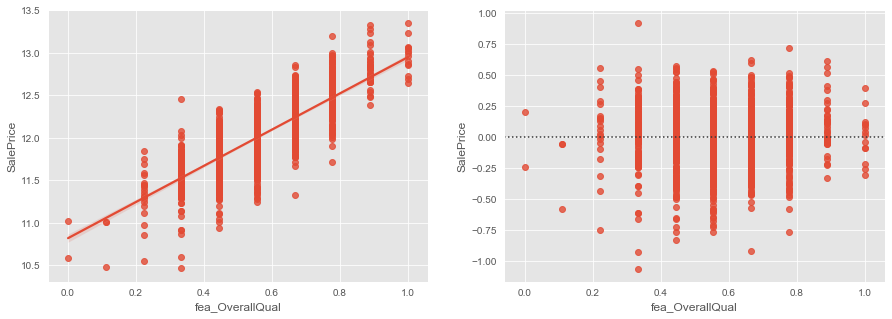

In [26]:
reg_with_one_exploratory_visualizer(df_train, 'fea_OverallQual', 'SalePrice')

In [27]:
import statsmodels.api as sm

In [28]:
# Note the difference in argument order
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train['fea_OverallQual'])).fit() ## sm.OLS(output, input)
predictions = model.predict( sm.add_constant(df_train['fea_OverallQual']))

# Print out the statistics
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     2964.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:12   Log-Likelihood:                 92.334
No. Observations:                1455   AIC:                            -180.7
Df Residuals:                    1453   BIC:                            -170.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.8166      0.023    4

In [29]:
d = pd.DataFrame()
d['res'] = predictions-y
d.shape

(1455, 1)

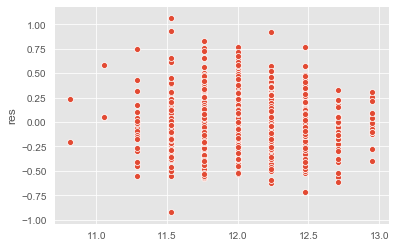

In [30]:
# In the residual by predicted plot, we see that the residuals are randomly scattered around the center line of zero, with no obvious non-random pattern.
# Residuals have constant variance
sns.scatterplot(predictions,d['res'])

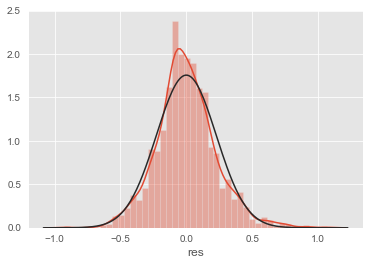

In [31]:
# Residuals are approximately normally distributed
sns.distplot(d['res'], kde=True, fit=st.norm )

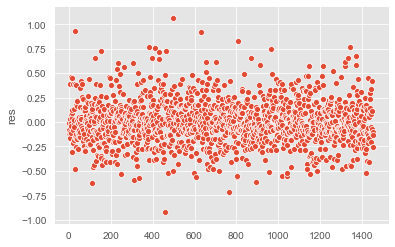

In [32]:
# No autocorrelation!! Residuals are independent one another, if doubt apply Durbin Watson
sns.scatterplot(d.index,d['res'])

# 2. REGRESSION WITH ALL FEATURES

In [33]:
X = df_train[fea_cols].values
y = df_train['SalePrice'].values

In [34]:
reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

0.9374859842064027

In [35]:
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train[fea_cols])).fit()
predictions = model.predict( sm.add_constant(df_train[fea_cols]))
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     118.0
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:13   Log-Likelihood:                 1300.4
No. Observations:                1455   AIC:                            -2271.
Df Residuals:                    1290   BIC:                            -1399.
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [36]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_train[fea_cols].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_train[fea_cols].values, i) 
                          for i in range(len(df_train[fea_cols].columns))]
vif_data

,feature,VIF
0,fea_MSSubClass,25.703355
1,fea_LotFrontage,170.835675
2,fea_LotFrontage_log,482.768823
3,fea_LotArea,6.327019
4,fea_LotArea_log,108.890447
5,fea_OverallQual,638.740078
6,fea_OverallCond,492.328785
7,fea_YearBuilt,145.263893
8,fea_YearRemodAdd,12.883601
9,fea_YrSold,3.533316


# 3. REGRESSION WITH FEATURES - BACKWARD ELIMINATION

In [37]:
X = df_train[fea_cols]
y = df_train['SalePrice']

cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)
print(len(selected_features_BE))

['fea_LotArea_log', 'fea_OverallQual', 'fea_OverallCond', 'fea_YearBuilt', 'fea_YearRemodAdd', 'fea_BsmtFinSF1', 'fea_TotalBsmtSF', 'fea_1stFlrSF_log', 'fea_2ndFlrSF', 'fea_GrLivArea_log', 'fea_BsmtFullBath', 'fea_BedroomAbvGr', 'fea_Fireplaces', 'fea_GarageCars', 'fea_GarageArea_log', 'fea_WoodDeckSF', 'fea_ScreenPorch', 'fea_TotalPorch', 'fea_MSZoning', 'fea_Street_Pave', 'fea_LandContour_HLS', 'fea_Neighborhood', 'fea_Condition1_Artery', 'fea_Condition1_Feedr', 'fea_Condition1_RRAe', 'fea_Condition2_PosN', 'fea_Exterior1st_BrkComm', 'fea_Exterior1st_BrkFace', 'fea_Exterior2nd_CmentBd', 'fea_Foundation_BrkTil', 'fea_Foundation_CBlock', 'fea_Foundation_Wood', 'fea_BsmtExposure', 'fea_Heating_GasW', 'fea_Heating_Grav', 'fea_HeatingQC', 'fea_CentralAir_Y', 'fea_KitchenQual', 'fea_Functional_Maj1', 'fea_Functional_Maj2', 'fea_Functional_Min2', 'fea_Functional_Mod', 'fea_Functional_Sev', 'fea_GarageType_2Types', 'fea_GarageType_Attchd', 'fea_GarageType_Basment', 'fea_GarageType_BuiltIn', 

In [38]:
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train[selected_features_BE])).fit()
predictions = model.predict( sm.add_constant(df_train[selected_features_BE]))
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     357.9
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:21   Log-Likelihood:                 1244.0
No. Observations:                1455   AIC:                            -2378.
Df Residuals:                    1400   BIC:                            -2088.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [39]:
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_train[selected_features_BE].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_train[selected_features_BE].values, i) for i in range(len(df_train[selected_features_BE].columns))]
vif_data

,feature,VIF
0,fea_LotArea_log,27.138993
1,fea_OverallQual,57.382065
2,fea_OverallCond,31.181578
3,fea_YearBuilt,62.216148
4,fea_YearRemodAdd,10.094369
5,fea_BsmtFinSF1,4.638647
6,fea_TotalBsmtSF,29.071777
7,fea_1stFlrSF_log,213.929585
8,fea_2ndFlrSF,25.758541
9,fea_GrLivArea_log,421.689951


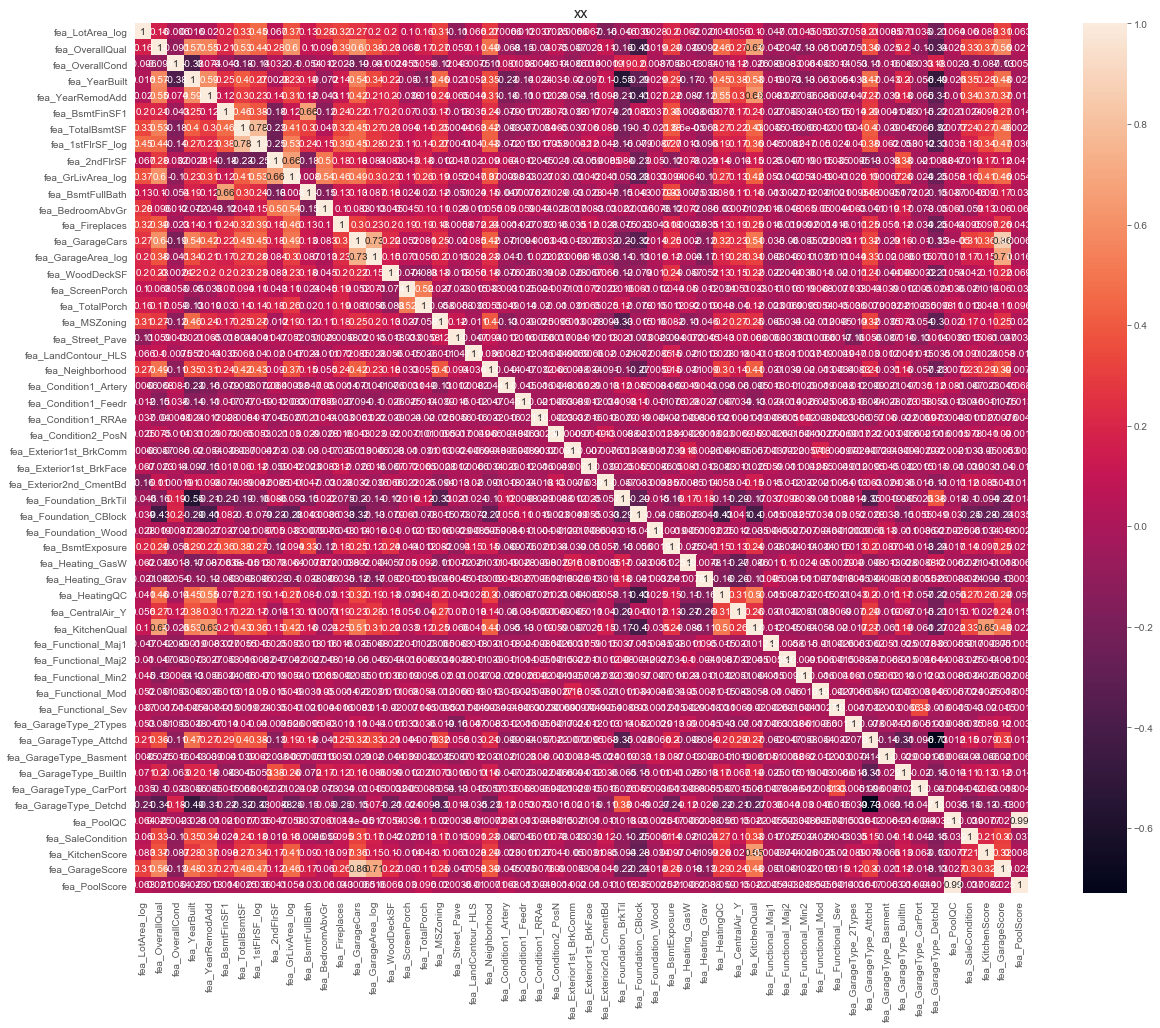

In [41]:
fig = plt.figure(figsize=(20,16) )
sns.heatmap( df_train[selected_features_BE].corr(),  annot=True  )
plt.title('xx')
plt.show()

# 4. REGRESSION WITH FEATURES DETERMINED BY CORRELATION

In [42]:
spearman = df_train.corr()['SalePrice'].reset_index().sort_values('SalePrice', ascending=False)
corred  = spearman[ (spearman['SalePrice'] >= 0.5) | (spearman['SalePrice'] <= -0.5) ]
print(corred.shape)
print(corred['index'].to_list())

(29, 2)
['SalePrice', 'fea_OverallQual', 'fea_AllSF', 'fea_AllSF_log', 'fea_GrLivArea_log', 'fea_GrLivArea', 'fea_ExterQual', 'fea_GarageCars', 'fea_KitchenQual', 'fea_GarageScore', 'fea_GarageArea', 'fea_TotalBsmtSF', 'fea_TotalBath', 'fea_1stFlrSF', 'fea_1stFlrSF_log', 'fea_GarageFinish', 'fea_OverallGrade', 'fea_FullBath', 'fea_YearBuilt', 'fea_ExterGrade', 'fea_BsmtQual', 'fea_YearRemodAdd', 'fea_Neighborhood', 'fea_FireplaceQu', 'fea_TotRmsAbvGrd', 'fea_Foundation_PConc', 'fea_FireplaceScore', 'fea_MSSubClass', 'fea_GarageYrBlt']


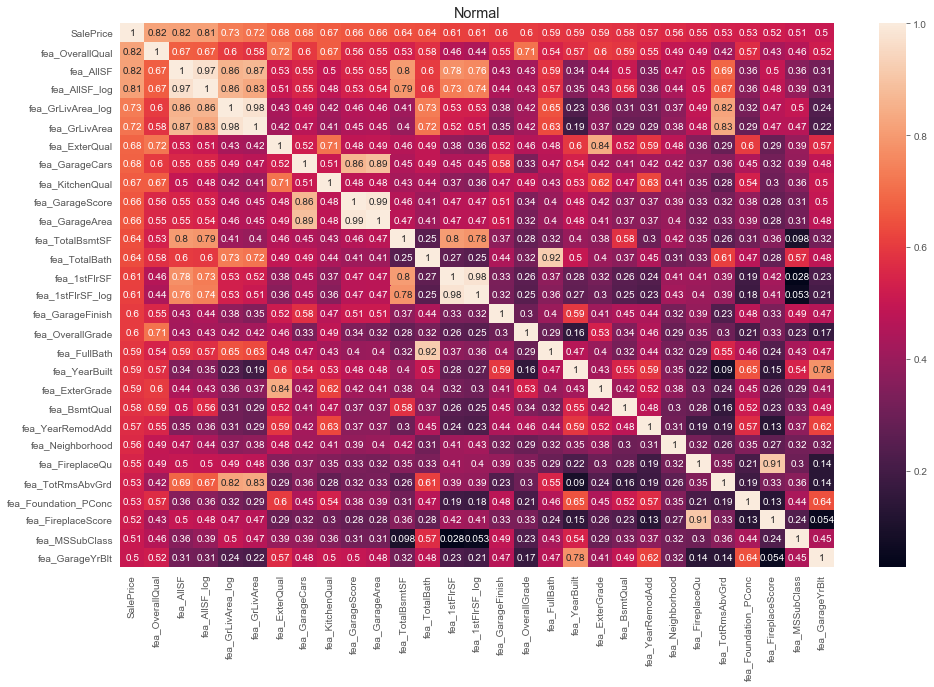

In [43]:
fig = plt.figure(figsize=(16,10) )
sns.heatmap( df_train[corred['index'].to_list() ].corr(),  annot=True   )
plt.title('Normal')
plt.show()

In [44]:
features_with_correlation = [ 'fea_GrLivArea_log', 'fea_KitchenQual', 'fea_GarageScore', 'fea_TotalBsmtSF_log',
                             'fea_1stFlrSF_log', 'fea_GarageFinish', 'fea_OverallGrade', 'fea_YearBuilt',
                             'fea_Neighborhood', 'fea_Foundation_PConc', 'fea_FireplaceScore']

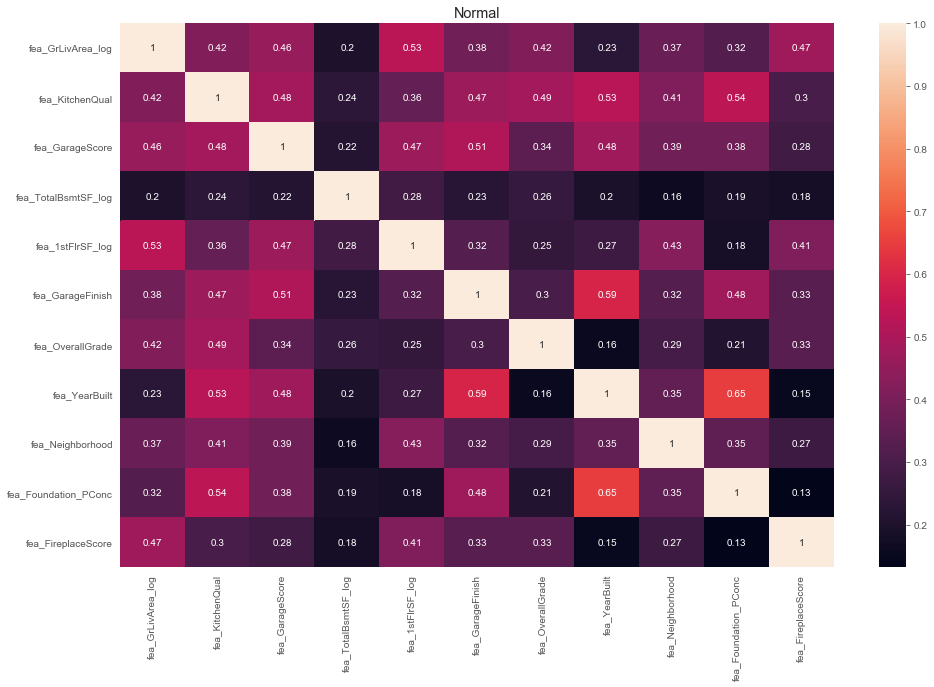

In [45]:
fig = plt.figure(figsize=(16,10) )
sns.heatmap( df_train[features_with_correlation].corr(),  annot=True   )
plt.title('Normal')
plt.show()

In [46]:
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train[features_with_correlation])).fit()
predictions = model.predict( sm.add_constant(df_train[features_with_correlation]))
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1019.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:                 863.13
No. Observations:                1455   AIC:                            -1702.
Df Residuals:                    1443   BIC:                            -1639.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.0364 

In [47]:
vif_data = pd.DataFrame() 
vif_data["feature"] = df_train[features_with_correlation].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_train[features_with_correlation].values, i) 
                          for i in range(len(df_train[features_with_correlation].columns))]

In [48]:
vif_data

,feature,VIF
0,fea_GrLivArea_log,33.806991
1,fea_KitchenQual,51.605354
2,fea_GarageScore,9.689335
3,fea_TotalBsmtSF_log,29.945708
4,fea_1stFlrSF_log,27.693118
5,fea_GarageFinish,8.789300
6,fea_OverallGrade,21.355022
7,fea_YearBuilt,26.149150
8,fea_Neighborhood,12.454106
9,fea_Foundation_PConc,3.054593


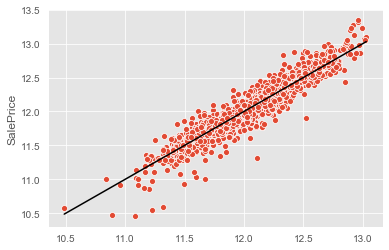

In [49]:
sns.scatterplot(predictions,y)
sns.lineplot(predictions,predictions, color='k')

In [50]:
d = pd.DataFrame()
d['res'] = predictions-y
d.shape

(1455, 1)

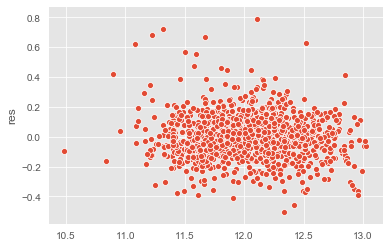

In [51]:
# In the residual by predicted plot, we see that the residuals are randomly scattered around the center line of zero, with no obvious non-random pattern.
# Residuals have constant variance
sns.scatterplot(predictions,d['res'])

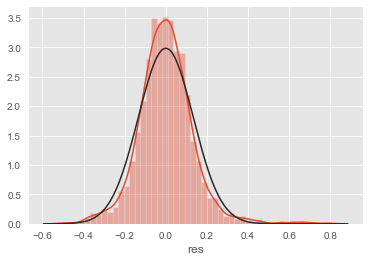

In [52]:
# Residuals are approximately normally distributed
sns.distplot(d['res'], kde=True, fit=st.norm )

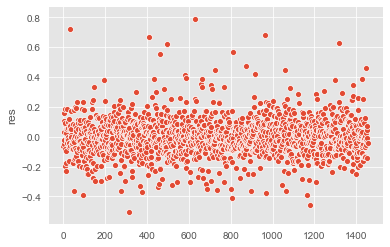

In [53]:
# No autocorrelation!! Residuals are independent one another, if doubt apply Durbin Watson
sns.scatterplot(d.index,d['res'])

# 5. REGRESSION WITH FEATURES DETERMINED BY f_regression

In [54]:
X = df_train[fea_cols]
y = df_train['SalePrice']

In [55]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X, y)
X_fs = fs.transform(X)

In [56]:
df_fs = pd.DataFrame()
df_fs['Feature'] = X.columns
df_fs['fs_score'] = fs.scores_
df_fs['fs_pvalue'] = fs.pvalues_

In [57]:
df_fs.sort_values('fs_score', ascending=False)

,Feature,fs_score,fs_pvalue
5,fea_OverallQual,2964.256560,0.000000e+00
168,fea_AllSF,2926.365789,0.000000e+00
169,fea_AllSF_log,2796.074182,0.000000e+00
22,fea_GrLivArea_log,1683.404936,4.826411e-245
21,fea_GrLivArea,1551.869866,1.620165e-231
111,fea_ExterQual,1261.545087,1.958131e-199
34,fea_GarageCars,1252.731674,2.083128e-198
131,fea_KitchenQual,1164.628894,5.915247e-188
166,fea_GarageScore,1103.087656,1.927590e-180
35,fea_GarageArea,1093.618270,2.864952e-179


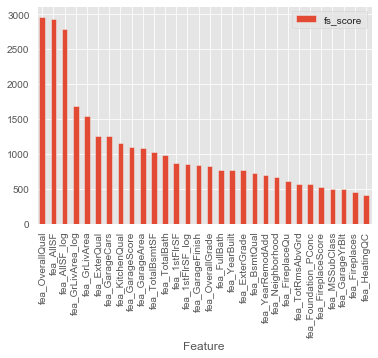

In [58]:
df_fs.sort_values('fs_score', ascending=False).head(30).plot( kind='bar', x='Feature', y='fs_score')

In [59]:
k = 12
features_from_fs_score = df_fs.sort_values('fs_score', ascending=False).head(k)['Feature'].to_list()
print(df_fs.sort_values('fs_score', ascending=False).head(k)['Feature'].to_list())

['fea_OverallQual', 'fea_AllSF', 'fea_AllSF_log', 'fea_GrLivArea_log', 'fea_GrLivArea', 'fea_ExterQual', 'fea_GarageCars', 'fea_KitchenQual', 'fea_GarageScore', 'fea_GarageArea', 'fea_TotalBsmtSF', 'fea_TotalBath']


In [60]:
features_from_fs_score = ['fea_OverallQual', 'fea_GrLivArea', 'fea_ExterQual', 'fea_KitchenQual', 'fea_GarageScore', 'fea_TotalBsmtSF', 'fea_TotalBath']

In [61]:
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train[features_from_fs_score])).fit()
predictions = model.predict( sm.add_constant(df_train[features_from_fs_score]))
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1087.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:40   Log-Likelihood:                 617.49
No. Observations:                1455   AIC:                            -1219.
Df Residuals:                    1447   BIC:                            -1177.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.5985      0.025    4

In [62]:
vif_data = pd.DataFrame() 
vif_data["feature"] = df_train[features_from_fs_score].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_train[features_from_fs_score].values, i) 
                          for i in range(len(df_train[features_from_fs_score].columns))]
vif_data

,feature,VIF
0,fea_OverallQual,44.932397
1,fea_GrLivArea,15.892331
2,fea_ExterQual,15.854077
3,fea_KitchenQual,30.962079
4,fea_GarageScore,8.994290
5,fea_TotalBsmtSF,11.745033
6,fea_TotalBath,20.548012


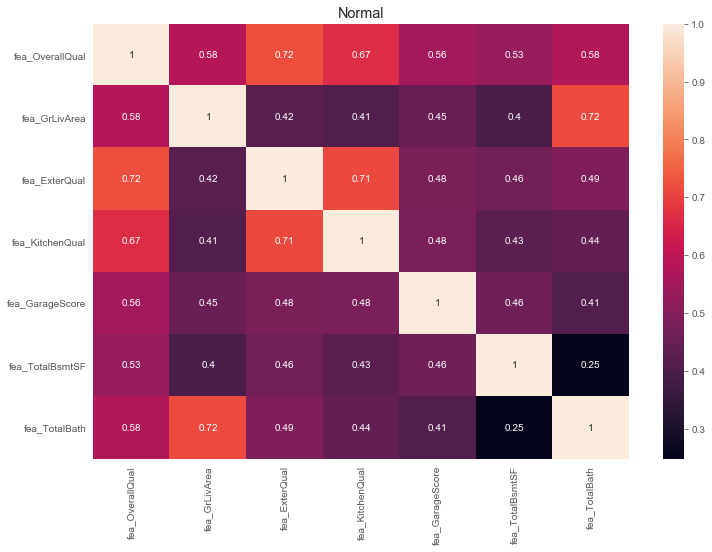

In [63]:
fig = plt.figure(figsize=(12,8) )
sns.heatmap( df_train[features_from_fs_score].corr(),  annot=True   )
plt.title('Normal')
plt.show()

# 6. REGRESSION WITH FEATURES DETERMINED BY Mutual Information

In [64]:
X = df_train[fea_cols]
y = df_train['SalePrice']

In [65]:
mir = SelectKBest(score_func=mutual_info_regression, k='all')
mir.fit(X, y)
X_mir = mir.transform(X)

In [66]:
df_mir = pd.DataFrame()
df_mir['Feature'] = X.columns
df_mir['mir_score'] = mir.scores_
df_mir['mir_pvalue'] = mir.pvalues_

In [67]:
df_mir.head()

,Feature,mir_score,mir_pvalue
0,fea_MSSubClass,0.200960,None
1,fea_LotFrontage,0.224393,None
2,fea_LotFrontage_log,0.215131,None
3,fea_LotArea,0.170674,None
4,fea_LotArea_log,0.199073,None


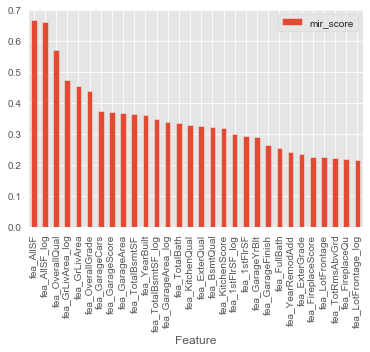

In [68]:
df_mir.sort_values('mir_score', ascending=False).head(30).plot( kind='bar', x='Feature', y='mir_score')

In [69]:
k = 12
features_from_mir_score = df_mir.sort_values('mir_score', ascending=False).head(k)['Feature'].to_list()
print(df_mir.sort_values('mir_score', ascending=False).head(k)['Feature'].to_list())

['fea_AllSF', 'fea_AllSF_log', 'fea_OverallQual', 'fea_GrLivArea_log', 'fea_GrLivArea', 'fea_OverallGrade', 'fea_GarageCars', 'fea_GarageScore', 'fea_GarageArea', 'fea_TotalBsmtSF', 'fea_YearBuilt', 'fea_TotalBsmtSF_log']


In [70]:
features_from_mir_score = ['fea_AllSF', 'fea_OverallQual','fea_OverallGrade', 'fea_GarageScore', 'fea_YearBuilt', 'fea_TotalBsmtSF_log']

In [71]:
model = sm.OLS( df_train['SalePrice'], sm.add_constant(df_train[features_from_mir_score])).fit()
predictions = model.predict( sm.add_constant(df_train[features_from_mir_score]))
print(model.summary())
print(mean_squared_error(y, predictions))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1581.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:46   Log-Likelihood:                 754.08
No. Observations:                1455   AIC:                            -1494.
Df Residuals:                    1448   BIC:                            -1457.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.5912    

In [72]:
vif_data = pd.DataFrame() 
vif_data["feature"] = df_train[features_from_mir_score].columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_train[features_from_mir_score].values, i) 
                          for i in range(len(df_train[features_from_mir_score].columns))]
vif_data

,feature,VIF
0,fea_AllSF,22.561642
1,fea_OverallQual,74.855593
2,fea_OverallGrade,33.215142
3,fea_GarageScore,9.540496
4,fea_YearBuilt,21.773450
5,fea_TotalBsmtSF_log,23.437944


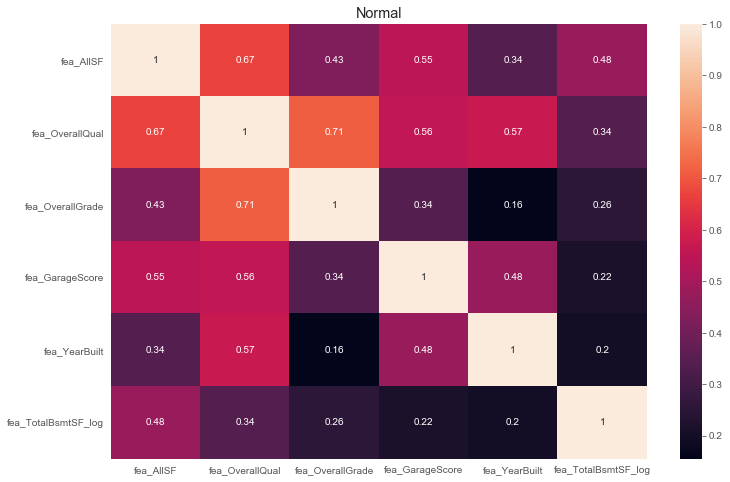

In [73]:
fig = plt.figure(figsize=(12,8) )
sns.heatmap( df_train[features_from_mir_score].corr(),  annot=True   )
plt.title('Normal')
plt.show()

# 7. RIDGE REGRESSION

In [74]:
X = df_train[fea_cols]
y = df_train['SalePrice']

In [79]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X, y)
alpha = ridge.alpha_
print("Best alpha :", alpha)
ridge.score(X, y)

Best alpha : 3.0


0.9328887195229423

In [86]:
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X, y)
alpha = ridge.alpha_
print("Best alpha :", alpha)
ridge.score(X, y)

Try again for more precision with alphas centered around 2.25
Best alpha : 2.25


0.933816769392684

# 8. RIDGE REGRESSION

In [88]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)
lasso.score(X, y)

Best alpha : 0.0003


0.9303111062819656

In [90]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)
lasso.score(X, y)

Try again for more precision with alphas centered around 0.0003
Best alpha : 0.000285


0.9305694366583939

# 9. ELASTICNET REGRESSION

# ................TO BE CONTINUED..............

In [ ]:
train['id'] = train['item_id'] + '_' + train['store_id']
print(train.shape)
print('-'*25)
train.head()

In [ ]:
# Making data usable in models
with timer():
    train = pd.melt( train,
                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                     value_vars = [col for col in train.columns if col.startswith("d_")],
                     var_name = "d",
                     value_name = "sales")
with timer():
    train['d']     = train['d'].str.extract('(\d+)').astype('int16')
    train['sales'] = train['sales'].astype('int16')


with timer():
    train.sort_values(['id', 'd'], inplace=True)


print(train.shape)
print('-'*25)
train.tail()

In [ ]:
# Adding the 28 days we try to forecast
with timer():
    tmp = train.groupby('id', as_index=False ).tail(28)
    tmp['d'] = tmp['d'] + 28
    tmp['sales'] = np.nan
    print(tmp.shape)

with timer():
    train = pd.concat([train,tmp], axis=0, sort=False, ignore_index=True)

del tmp; gc.collect()

with timer():
    train.sort_values(['id', 'd'], inplace=True)
    train.reset_index(drop=True, inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

In [ ]:
## Adding lag days
def lagger(train, lag_day):
    train[f'sales_lag_{lag_day}'] = train[['id', 'd', 'sales']].groupby('id')['sales'].transform( lambda x: x.shift(lag_day) ).astype('float16')
    return train

In [ ]:
for i in [1,2,3,4,5,6,7,8,12,13,14,15,28]:
    train = lagger(train,i)
    print(i, 'DONE')

In [ ]:
print(train.shape)
print('-'*25)
train.tail()

### 2.2. CALENDAR DATA PREPARATION

In [ ]:
print(calendar.shape)
print('-'*25)
calendar.tail()

In [ ]:
with timer():
    calendar['d'] = calendar['d'].str.extract('(\d+)').astype('int16')
    
    calendar['day'] = pd.to_datetime(calendar['date']).dt.day
    
    for col in ['wday', 'month', 'wm_yr_wk', 'year']:
        calendar[col] = calendar[col].astype('int16')
    
    calendar.drop(['date', 'weekday'], axis=1, inplace=True)
        
print(calendar.shape)
print('-'*25)
calendar.tail()

In [ ]:
## DO NOT FORGET TO ADD SNAP DATA
snap = calendar[['d', 'snap_CA', 'snap_TX', 'snap_WI']]

snap = pd.melt( snap,
                     id_vars = ['d'],
                     value_vars = [col for col in snap.columns if col.startswith("snap_")],
                     var_name = "state_id",
                     value_name = "is_snap")

snap['state_id'] = snap['state_id'].str[5:].astype('category')
snap['is_snap'] = snap['is_snap'].astype('int8')

print(snap.shape)
print('-'*25)
snap.tail()

In [ ]:
calendar.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

In [ ]:
tmp = pd.get_dummies(calendar['event_name_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)


tmp = pd.get_dummies(calendar['event_name_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

calendar.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], axis=1, inplace=True)
del tmp; gc.collect()

print(calendar.shape)
print('-'*25)
calendar.tail(5)

In [ ]:
calendar['Cinco De Mayo']    = calendar['Cinco De Mayo']   + calendar['2_Cinco De Mayo']
calendar['Easter']           = calendar['Easter']          + calendar['2_Easter']
calendar['Father\'s day']    = calendar['Father\'s day']   + calendar['2_Father\'s day']
calendar['OrthodoxEaster']   = calendar['OrthodoxEaster']  + calendar['2_OrthodoxEaster']
calendar['Cultural']         = calendar['Cultural']        + calendar['2_Cultural']
calendar['Religious']        = calendar['Religious']       + calendar['2_Religious']

calendar.drop([col for col in calendar.columns if col.startswith('2_')], axis=1, inplace=True)

print(calendar.shape)
print('-'*25)
calendar.tail(5)

In [ ]:
calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Ramadan starts' ]  = 1

calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Religious' ]  = 1


In [ ]:
calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Eid al-Fitr' ]  = 1

calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Religious' ]  = 1

In [ ]:
calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'EidAlAdha' ]  = 1

calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'Religious' ]  = 1

In [ ]:
calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'NBAFinalsStart' ]  = 1

calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'Sporting' ]  = 1

calendar.drop(['NBAFinalsEnd'], axis=1, inplace=True)

In [ ]:
# Merging calendar 
with timer():
    train = train.merge(calendar, on='d', how='left')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del calendar; gc.collect()

In [ ]:
train.info()

### 2.3. PRICE DATA PREPARATION

In [ ]:
print(prices.shape)
print('-'*25)
prices.head()

In [ ]:
prices['sell_price_over_mean']   = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')   ) - 1
prices['sell_price_over_median'] = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('median') ) - 1

prices['sell_price_over_mean']   = prices['sell_price_over_mean'  ].astype('float16')
prices['sell_price_over_median'] = prices['sell_price_over_median'].astype('float16')

print(prices.shape)
print('-'*25)
prices.head()

In [ ]:
# Merging prices 
with timer():
    train = train.merge(prices, on=['item_id','store_id','wm_yr_wk'], how='inner')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del prices; gc.collect()

In [ ]:
for col in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    train[col] = train[col].astype('category')

## 3 FEATURE ENGINEERING

In [ ]:
## DO NOT FORGET TO ADD SNAP DATA
with timer():
    train = train.merge(snap, on=['d', 'state_id'], how='left')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del snap; gc.collect()

### Feature 0  >>>  id based nonzero statistics

In [ ]:
## With this id is obsolete
f0 = train[train['sales'] > 0 ].groupby('id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f0.columns = [ f[0] if f[1] == '' else 'id_nonzero_' + f[0] + '_' + f[1] for f in f0.columns ]

print(f0.shape)
print('-'*25)
f0.tail()

In [ ]:
# Merging f0
with timer():
    train = train.merge(f0, on='id', how='left')

del f0; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 1  >>>  id based statistics

In [ ]:
## With this id is obsolete
f1 = train.groupby('id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f1.columns = [ f[0] if f[1] == '' else 'id_' + f[0] + '_' + f[1] for f in f1.columns ]

print(f1.shape)
print('-'*25)
f1.tail()

In [ ]:
# Merging f1
with timer():
    train = train.merge(f1, on='id', how='left')

del f1; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 2  >>>  item_id based statistics

In [ ]:
## With this item_id is obsolete
f2 = train.groupby('item_id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f2.columns = [ f[0] if f[1] == '' else 'item_id_' + f[0] + '_' + f[1] for f in f2.columns ]

print(f2.shape)
print('-'*25)
f2.tail()

In [ ]:
# Merging f2
with timer():
    train = train.merge(f2, on='item_id', how='left')

del f2; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 3  >>>  dept_id based statistics

In [ ]:
## With this dept_id is obsolete
f3 = train.groupby('dept_id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f3.columns = [ f[0] if f[1] == '' else 'dept_id_' + f[0] + '_' + f[1] for f in f3.columns ]

print(f3.shape)
print('-'*25)
f3.tail()

In [ ]:
# Merging f3
with timer():
    train = train.merge(f3, on='dept_id', how='left')

del f3; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

for store in store_list:
    with timer():
        print(store)
        train[train['store_id'] == store].to_csv(f'{path}FE3/Train_Data_2_{store}.csv', index=False)

# STORE BASED FEATURE ENGINEERING AND MODELLING

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

print('** M5 - FORECASTING - ACCURACY **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

path = 'input/'
out_path = 'output/FE3/'

print ("Initiation is DONE !!")
print("-"*25)

In [ ]:
##### SOME USEFUL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )

### Store Feature 4 >>> id-monthdaily based statistics

In [ ]:
def feature4(train):
    f4 = train.groupby(['id', 'day']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f4.columns = [ f[0] if f[1] == '' else 'id_day_' +  f[0] + '_' + f[1] for f in f4.columns ]

    with timer():
        train = train.merge(f4, on=['id', 'day'], how='left')

    del f4; gc.collect()
    
    return train

### Store Feature 5 >>> id-weekdaily based statistics

In [ ]:
def feature5(train):
    f5 = train.groupby(['id', 'wday']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f5.columns = [ f[0] if f[1] == '' else 'id_wday_' +  f[0] + '_' + f[1] for f in f5.columns ]
    
    with timer():
        train = train.merge(f5, on=['id', 'wday'], how='left')

    del f5; gc.collect()
    
    return train

### Store Feature 6 >>> id-monthly based statistics

In [ ]:
def feature6(train):
    f6 = train.groupby(['id', 'month']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f6.columns = [ f[0] if f[1] == '' else 'id_month_' + f[0] + '_' + f[1] for f in f6.columns ]

    with timer():
        train = train.merge(f6, on=['id', 'month'], how='left')

    del f6; gc.collect()
    
    return train

### Store Feature 7 >>> event based statistics

In [ ]:
def feature7(train):
    
    event_cat = ['Cultural', 'National', 'Religious', 'Sporting']

    for event in event_cat:

        with timer():
            f7 = train[train[f'{event}'] > 0 ].groupby(['id']).agg({ 'sales': ['mean', 'std'] }).reset_index()
            f7.columns = [ f[0] if f[1] == '' else f'id_{event}_' + f[0] + '_' + f[1] for f in f7.columns ]
            f7[f'{event}'] = 1

            train = train.merge(f7, on=['id', f'{event}'], how='left')
            new_cols = [col for col in train.columns if col.startswith(f'id_{event}_')]

            for c in new_cols:
                train[c] = train[c].fillna(0)

            del f7; gc.collect()

    return train

### Prediction Function

In [ ]:
def predictor(model, store, pred, y_true, param_name, submission, feature_columns_to_keep):

    print('-'*25)
    print( 'MODEL PREDICTION BEGAN ...' )
    print('-'*25)
    
    
    y_pred = model.predict(pred[feature_columns_to_keep])
    x_pred = pred.copy()

    x_pred['y_true'] = y_true
    x_pred['y_pred'] = y_pred
    x_pred['y_pred'] = x_pred['y_pred'].apply(lambda x: 0 if x<0 else x)
    
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['id'] == f'FOODS_3_013_{store}' ) ] , color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['id'] == f'FOODS_3_013_{store}' ) ] , color='b')
    plt.show()
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['id'] == f'HOUSEHOLD_2_102_{store}' ) ], color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['id'] == f'HOUSEHOLD_2_102_{store}' ) ], color='b')
    plt.show()    

    
    res_val  = x_pred[x_pred['d'] <= 1941][['id', 'd', 'y_pred']].copy()
    res_eval = x_pred[x_pred['d'] > 1941][['id', 'd', 'y_pred']].copy() 

    res_val['id']  = res_val['id'].astype(str)  + '_validation'
    res_eval['id'] = res_eval['id'].astype(str)  + '_evaluation'

    res_val             = res_val.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval            = res_eval.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval.columns    = res_val.columns

    res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
    res            = submission[['id']].merge(res, on='id', how='inner')
    res.columns    = submission.columns

    res.to_csv(f'{out_path}model_lgbm_2_{store}_' + param_name + '.csv', index=False)

    
    del x_pred, y_pred, res_val, res_eval, res; gc.collect()
    
    print('-'*25)
    print( 'MODEL PREDICTION COMPLETED !!!' )
    print('-'*25)

## The Real Deal

In [ ]:
submission = pd.read_csv( f'{path}sample_submission.csv')

store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

for store in store_list:
    train = pd.read_csv(f'{path}FE3/Train_Data_2_{store}.csv')
    
    train = feature4(train)
    train = feature5(train)
    train = feature6(train)
    train = feature7(train)
    
    cols_to_drop = ['item_id', 'store_id', 'state_id', 'wm_yr_wk']
    event_cat = ['Cultural', 'National', 'Religious', 'Sporting']
    
    train.drop(cols_to_drop, axis=1, inplace=True)
    train.drop(event_cat, axis=1, inplace=True)
    
    cat_cols = ['id', 'dept_id', 'cat_id' ]
    for col in cat_cols:
        train[col] = train[col].astype('category') 

    pred = train[train['d'] > 1913]
    y_true = pred['sales']
    pred = pred.drop('sales', axis=1)

    valid = train[ (train['d'] <= 1941) & (train['d'] > 1913) ]
    y_valid = valid['sales']
    x_valid = valid.drop('sales', axis=1)

    x_train = train.drop('sales', axis=1)
    y_train = train['sales']

    feature_columns_to_keep = [col for col in x_train.columns if col != 'd' ] # if ((col != 'id') & (col != 'd')) ]

    train_data = lgb.Dataset( x_train[feature_columns_to_keep], categorical_feature=cat_cols, label = y_train, free_raw_data=False )
    valid_data = lgb.Dataset( x_valid[feature_columns_to_keep], categorical_feature=cat_cols, label = y_valid, free_raw_data=False )

    del valid, x_train, x_valid, y_train, y_valid ; gc.collect()
    
    
    res_rmse = pd.DataFrame()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = feature_columns_to_keep


    obj_list   = [ 'regression', 'poisson']   # , 'tweedie' 
    boost_list = [ 'gbdt']
    lr_list    = [ 0.7, 0.5, 0.3 ]
    l1_list    = [ 0 ]
    l2_list    = [ 0 ]

    i=0


    for obj in obj_list:
        for boost in boost_list:
            for lr in lr_list: 
                for l1 in l1_list:
                    for l2 in l2_list:
                        i += 1

                        params = {
                        # 'regression', 'regression_l1', 'tweedie',  'poisson', 'quantile', 'gamma', 'multiclass', 'cross_entropy'
                        'objective'         : obj        ,

                        #
                        # 'num_class'         : len(set(train_data.label)) ,

                        # 'gbdt', 'rf', 'dart', 'goss'
                        'boosting'          : boost      ,

                        # number of boosting iterations (100)  - [0, )
                        'num_iterations'    : 6000        ,    

                        # shrinkage rate (0.1) - [0, )
                        'learning_rate'     : lr         ,

                        # 'serial', 'feature', 'data', 'voting'
                        'tree_learner'      : 'serial'   ,

                        # if there are too many rows make it True, if there are too many columns make 'force_col_wise' option True
                        # Never make them both True
                        'force_row_wise'    : True       ,

                        # if the data is small use it otherwise don't touch it
                        'max_depth'         : -1         ,

                        # 20 - [0, )
                        'min_data_in_leaf'  : 31         , 

                        # randomly select part of data without resampling, to enable bagging it must be smaller than 1 (0,1]
                        # 'bagging_fraction'  : 1          ,

                        # to enable bagging bagging_freq must be nonzero [0, )
                        #'bagging_freq'      : 0          ,

                        # randomly select features, to enable featuring it must be smaller than 1 (0,1]
                        # 'feature_fraction'  : 1          ,

                        # stops training if one metric of one validation data does not improve in the last x rounds (0)
                        'early_stopping_round' : 1000     ,

                        # (0)
                        'lambda_l1'         : l1         ,

                        # (0)
                        'lambda_l2'         : l2          ,

                        #controls the level of LGBM verbosity
                        'verbosity'         : 1          ,  

                        # 'rmse', 'auc', 'l1', 'l2', 'tweedie', 'poissson', 'multi_logloss'..
                        'metric'            : 'rmse'      ,

                        # Use these 3 parameters to handle memory error
                        # -----------------------------------------------------
                        # max number of leaves in one tree (31) - [1,131072]
                        'num_leaves'              : 128    , 
                        # max cache size in MB for historical histogram (-1)
                        #'histogram_pool_size'     : 128   ,
                        # max number of bins that feature values will be bucketed in (255) - 
                        #'max_bin'                 : 31    ,
                        # -----------------------------------------------------

                        'random_state': 28,

                        }

                        with timer():
                            model = lgb.train(params, train_data, 1000, valid_sets = [valid_data], categorical_feature=cat_cols, verbose_eval=100 ) 
                            mtrc_rmse = model.best_score['valid_0']['rmse']
                            param_name = f'{i}_{obj}_{boost}_{str(lr)}_{str(l1)}_{str(l2)}_{str(mtrc_rmse)}'


                        model.save_model(f'{out_path}model_lgbm_2_{store}_' + param_name + '.txt')

                        res_rmse = res_rmse.append( pd.DataFrame( {  'i': [i],
                                                 'objective': [obj],
                                                 'boosting': [boost],
                                                 'learning_rate':[lr], 
                                                 'l1':[l1], 
                                                 'l2':[l2], 
                                                 'RMSE': [mtrc_rmse]  } ) )

                        feature_importances[param_name] = model.feature_importance()               

                        plt.figure( figsize=(12,8) )
                        sns.barplot( x    = param_name,
                                     y    = 'feature',
                                     data = feature_importances.sort_values(param_name, ascending = False ) )
                        plt.title('LGBM Feature Importance ' + store + ' ' + param_name)
                        plt.show()

                        predictor(model, store, pred, y_true, param_name, submission, feature_columns_to_keep)

                        print('-'*25)
                        print( res_rmse )
                        print('-'*25)


    res_rmse.to_excel(f'{out_path}res_rmse_{store}.xlsx', index=False)                 
    feature_importances.to_excel(f'{out_path}feature_importances_{store}.xlsx', index=False) 


In [ ]:
for x in os.listdir("output/"):
    if x.

In [ ]:
matching = [e for e in os.listdir("output/") if (("model_lgbm_2" in e ) & ("regression_gbdt_0.5" in e ) & (".csv" in e ) ) ]
matching

In [ ]:
df = pd.DataFrame()
for doc in matching:
    df = df.append( pd.read_csv('output/' + doc) )

print(df.shape)
df.head()

In [ ]:
df = df[ df['F1'].notnull() ]
print(df.shape)
df.head()

In [ ]:
col_list = [col for col in df.columns if col.startswith("F")]

In [ ]:
for col in col_list:
    df[col] = df[col].apply(lambda x: 0 if x<0 else x)

In [ ]:
df.to_csv('model_lgbm_2_1_regression_gbdt_0.5_0_0.csv', index=False)

In [ ]:
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [ ]:
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

In [ ]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': 1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons